In [1]:
!pip install kagglehub


   ---------------------------------------- 0/3 [tqdm]
   ---------------------------------------- 0/3 [tqdm]
   ---------------------------------------- 0/3 [tqdm]
   ---------------------------------------- 0/3 [tqdm]
   ---------------------------------------- 0/3 [tqdm]
   ---------------------------------------- 0/3 [tqdm]
   ---------------------------------------- 0/3 [tqdm]
   ---------------------------------------- 0/3 [tqdm]
   ---------------------------------------- 0/3 [tqdm]
   ---------------------------------------- 0/3 [tqdm]
   ---------------------------------------- 0/3 [tqdm]
   ---------------------------------------- 0/3 [tqdm]
   ---------------------------------------- 0/3 [tqdm]
   ---------------------------------------- 0/3 [tqdm]
   ------------- -------------------------- 1/3 [pyyaml]
   ------------- -------------------------- 1/3 [pyyaml]
   ------------- -------------------------- 1/3 [pyyaml]
   ------------- -------------------------- 1/3 [pyyaml]
 

In [20]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mashlyn/online-retail-ii-uci")

print("Path to dataset files:", path)

Resuming download from 0 bytes (15217139 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/mashlyn/online-retail-ii-uci?dataset_version_number=3 (0/15217139) bytes left.


100%|██████████| 14.5M/14.5M [00:03<00:00, 3.97MB/s]

Extracting files...


Path to dataset files: C:\Users\pushk\.cache\kagglehub\datasets\mashlyn\online-retail-ii-uci\versions\3


In [6]:
# ...existing code...
# Transfer Kaggle dataset cache to project raw data folder
import shutil, os
from pathlib import Path

src = Path(r"c:\Users\pushk\.cache\kagglehub\datasets\mashlyn\online-retail-ii-uci\versions\3")
dest_root = Path(r"E:\AI-Powered Customer Segmentation\data\raw")
dest_root.mkdir(parents=True, exist_ok=True)

# Copy into a subfolder named 'ecommerce-dataset'
dest = dest_root / "ecommerce-dataset"
if dest.exists():
    print(f"Destination {dest} already exists. Skipping copy.")
else:
    shutil.copytree(src, dest)
    print(f"Copied {src} -> {dest}")
# ...existing code...

Copied c:\Users\pushk\.cache\kagglehub\datasets\mashlyn\online-retail-ii-uci\versions\3 -> E:\AI-Powered Customer Segmentation\data\raw\ecommerce-dataset


In [ ]:
# Environment Check: Ensure Plotly can render (nbformat requirement)
import sys, subprocess

def ensure(package_import_name: str, install_spec: str | None = None):
    try:
        __import__(package_import_name)
    except ImportError:
        spec = install_spec or package_import_name
        print(f"Installing {spec} ...")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', spec])

# nbformat is needed for inline rich mime rendering
ensure('nbformat', 'nbformat>=5.10.0')

# (Optional) ipywidgets can enhance some interactive figures; skip if not wanted
# ensure('ipywidgets', 'ipywidgets>=8.0.0')

import plotly.io as pio
try:
    import nbformat  # noqa: F401
    # Prefer in-notebook renderer; fallback to browser if something goes wrong
    preferred = ['notebook_connected', 'vscode', 'colab', 'jupyterlab']
    # Pick the first available renderer
    for r in preferred:
        if r in pio.renderers:
            pio.renderers.default = r
            break
    else:
        pio.renderers.default = 'browser'
except Exception:
    pio.renderers.default = 'browser'

print('Plotly default renderer set to:', pio.renderers.default)

In [21]:
# Exploratory Data Analysis - Setup & Data Loading (Enhanced)
import os, glob, math, textwrap, re
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

pd.set_option('display.max_columns', 50)
plt.style.use('seaborn-v0_8')

# Point to raw root; we'll search recursively (handles subfolder like 'ecommerce-dataset')
DATA_DIR = Path(r"E:\AI-Powered Customer Segmentation\data\raw")
assert DATA_DIR.exists(), f"Data directory not found: {DATA_DIR}"

csv_files = sorted([p for p in DATA_DIR.rglob('*.csv')])
if not csv_files:
    raise FileNotFoundError(f"No CSV files found under {DATA_DIR} (searched recursively)")

frames = []
for f in csv_files:
    try:
        tmp = pd.read_csv(f)
        if tmp.empty: 
            continue
        tmp['__source_file'] = f.relative_to(DATA_DIR).as_posix()
        frames.append(tmp)
    except Exception as e:
        print(f"WARN: Could not read {f.name}: {e}")

if not frames:
    raise RuntimeError("All CSV reads failed or were empty.")

df = pd.concat(frames, ignore_index=True)

# Standardize column names: lowercase, replace spaces & hyphens with underscore
original_cols = df.columns.tolist()
col_map_basic = {c: re.sub(r'[^0-9a-zA-Z]+', '_', c.strip().lower()).strip('_') for c in df.columns}
df.rename(columns=col_map_basic, inplace=True)

# Additional semantic normalization for known variants
rename_semantic = {}
cols_now = set(df.columns)
if 'invoicedate' in cols_now and 'invoice_date' not in cols_now:
    rename_semantic['invoicedate'] = 'invoice_date'
if 'price' in cols_now and 'unit_price' not in cols_now:
    rename_semantic['price'] = 'unit_price'
if 'customerid' in cols_now and 'customer_id' not in cols_now:
    rename_semantic['customerid'] = 'customer_id'
if rename_semantic:
    df.rename(columns=rename_semantic, inplace=True)

# Parse invoice_date if present
if 'invoice_date' in df.columns:
    df['invoice_date'] = pd.to_datetime(df['invoice_date'], errors='coerce', dayfirst=True)

print(f"Loaded {len(csv_files)} CSV files")
print(f"Row count: {len(df):,}; Columns: {len(df.columns)}")
print("Column name normalization:")
for o in original_cols:
    new = col_map_basic.get(o, o)
    if new in rename_semantic:
        new = rename_semantic[new]
    print(f"  {o} -> {new}")

missing_for_rfm = [c for c in ['customer_id','invoice_date'] if c not in df.columns]
if missing_for_rfm:
    print("NOTE: Still missing columns needed for RFM:", missing_for_rfm)
else:
    print("All core RFM columns present (customer_id, invoice_date).")

if 'unit_price' not in df.columns:
    print("INFO: 'unit_price' not found; monetary value will fallback if possible.")

print("Final columns:")
print(sorted(df.columns))

df.head(3)

Loaded 1 CSV files
Row count: 1,067,371; Columns: 9
Column name normalization:
  Invoice -> invoice
  StockCode -> stockcode
  Description -> description
  Quantity -> quantity
  InvoiceDate -> invoice_date
  Price -> unit_price
  Customer ID -> customer_id
  Country -> country
  __source_file -> source_file
All core RFM columns present (customer_id, invoice_date).
Final columns:
['country', 'customer_id', 'description', 'invoice', 'invoice_date', 'quantity', 'source_file', 'stockcode', 'unit_price']


,invoice,stockcode,description,quantity,invoice_date,unit_price,customer_id,country,source_file
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-01-12 07:45:00,6.95,13085.0,United Kingdom,online_retail_II.csv
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-01-12 07:45:00,6.75,13085.0,United Kingdom,online_retail_II.csv
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-01-12 07:45:00,6.75,13085.0,United Kingdom,online_retail_II.csv


In [26]:
# Data Quality & Basic Cleaning

summary = pd.DataFrame({
    'dtype': df.dtypes,
    'n_null': df.isna().sum(),
    'null_pct': (df.isna().mean()*100).round(2),
    'n_unique': df.nunique()
}).sort_values('null_pct', ascending=False)

display(summary)

# Drop obvious fully null columns ( >95% null )
hi_null_cols = summary[summary.null_pct > 95].index.tolist()
if hi_null_cols:
    print('Dropping high-null columns:', hi_null_cols)
    df.drop(columns=hi_null_cols, inplace=True)

# Remove rows with no CustomerID if needed for customer-level analyses (keep a copy)
if 'customer_id' in df.columns:
    df_cust = df.dropna(subset=['customer_id']).copy()
    df_cust['customer_id'] = df_cust['customer_id'].astype(str)
else:
    df_cust = df.copy()

# Create total_price (Quantity * UnitPrice) if exists
for q_col in ['quantity']:
    if q_col in df.columns and 'unit_price' in df.columns and 'total_price' not in df.columns:
        df['total_price'] = df[q_col] * df['unit_price']
        df_cust['total_price'] = df_cust[q_col] * df_cust['unit_price']

print('Rows after cleaning (customer subset):', len(df_cust))
df_cust.head(3)

,dtype,n_null,null_pct,n_unique
invoice_date,datetime64[ns],616193,57.73,19709
customer_id,float64,243007,22.77,5942
description,object,4382,0.41,5698
invoice,object,0,0.00,53628
stockcode,object,0,0.00,5305
quantity,int64,0,0.00,1057
unit_price,float64,0,0.00,2807
country,object,0,0.00,43
source_file,object,0,0.00,1
total_price,float64,0,0.00,9113


Rows after cleaning (customer subset): 824364


,invoice,stockcode,description,quantity,invoice_date,unit_price,customer_id,country,source_file,total_price
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-01-12 07:45:00,6.95,13085.0,United Kingdom,online_retail_II.csv,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-01-12 07:45:00,6.75,13085.0,United Kingdom,online_retail_II.csv,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-01-12 07:45:00,6.75,13085.0,United Kingdom,online_retail_II.csv,81.0


Numeric columns: ['quantity', 'unit_price', 'customer_id', 'total_price']


,count,mean,std,min,25%,50%,75%,max
quantity,1067371.0,9.938898,172.705794,-80995.00,1.00,3.0,10.00,80995.0
unit_price,1067371.0,4.649388,123.553059,-53594.36,1.25,2.1,4.15,38970.0
customer_id,824364.0,15324.638504,1697.464450,12346.00,13975.00,15255.0,16797.00,18287.0
total_price,1067371.0,18.069866,292.420223,-168469.60,3.75,9.9,17.70,168469.6


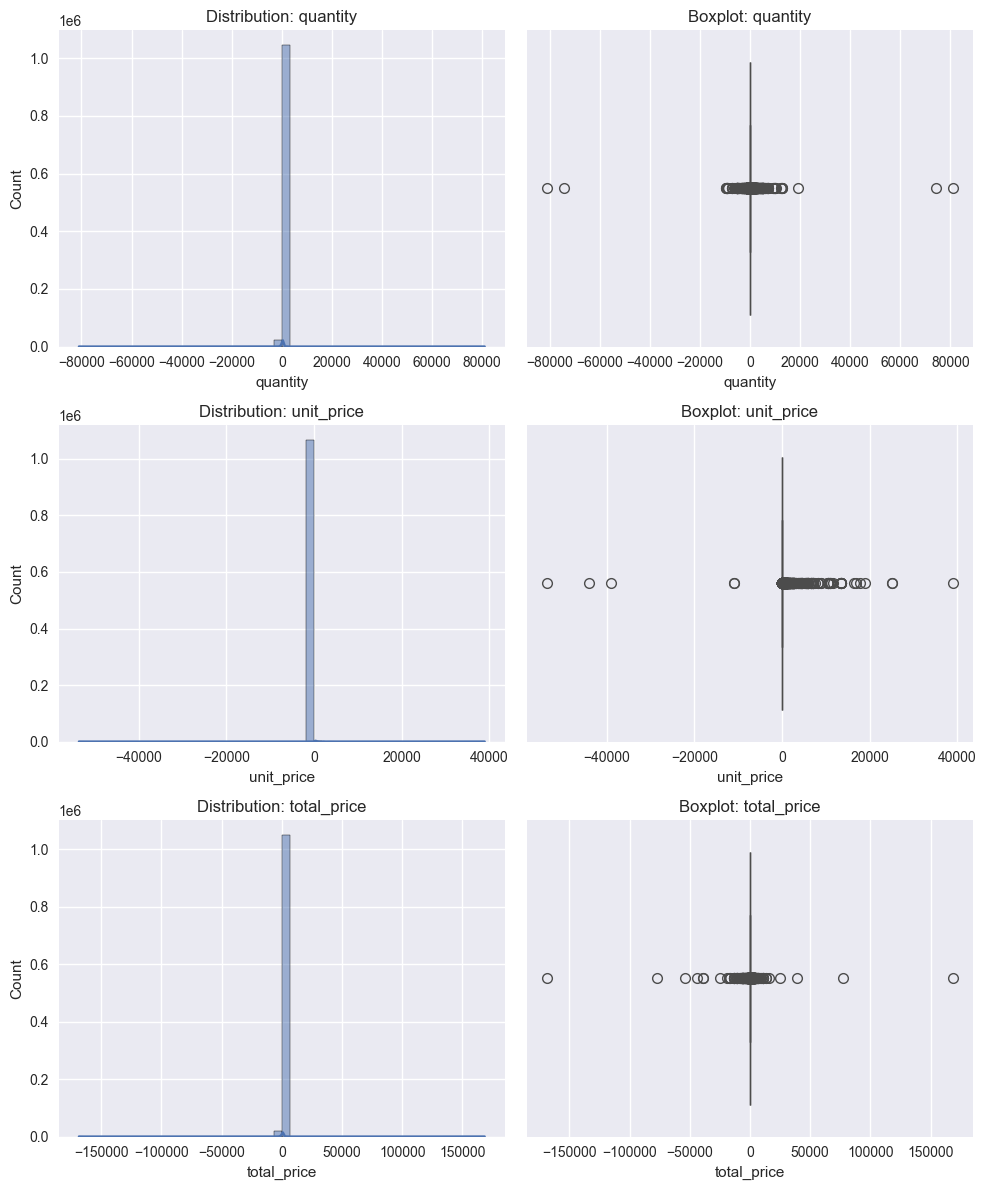

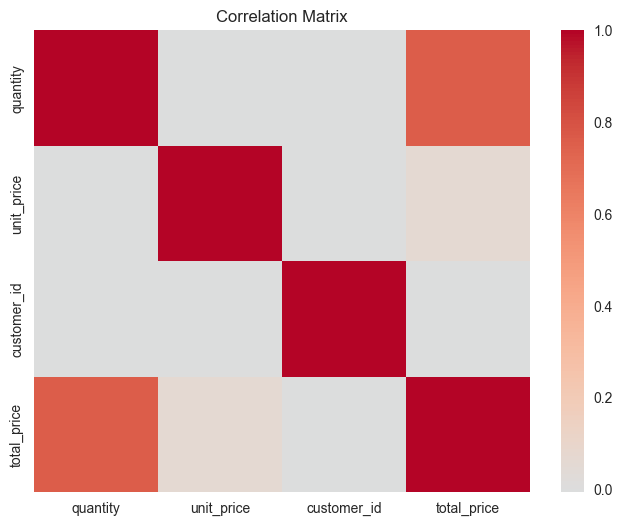

In [23]:
# Descriptive Statistics & Distributions
num_cols = df.select_dtypes(include=['number']).columns.tolist()
print('Numeric columns:', num_cols)

desc = df[num_cols].describe().T
display(desc)

# Histograms for key metrics
plot_cols = [c for c in ['quantity','unit_price','total_price'] if c in df.columns]
fig, axes = plt.subplots(len(plot_cols), 2, figsize=(10, 4*len(plot_cols)))
if len(plot_cols) == 1:
    axes = np.array([[axes[0], axes[1]]]) if isinstance(axes, np.ndarray) else np.array([[axes, axes]])
for i, c in enumerate(plot_cols):
    sns.histplot(df[c], ax=axes[i,0], kde=True, bins=50)
    axes[i,0].set_title(f'Distribution: {c}')
    sns.boxplot(x=df[c], ax=axes[i,1], orient='h')
    axes[i,1].set_title(f'Boxplot: {c}')
plt.tight_layout()
plt.show()

# Correlation heatmap
corr = df[num_cols].corr(numeric_only=True)
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

RFM snapshot:


,recency,frequency,monetary,R_score,F_score,M_score,RFM_sum
customer_id,,,,,,,
12346.0,610.0,17,-64.68,1,4,1,6
12347.0,96.0,8,5633.32,3,3,4,10
12348.0,221.0,5,2019.40,2,3,3,8
12349.0,973.0,5,4404.54,1,3,4,8
12350.0,312.0,1,334.40,2,1,2,5


RFM shape: (5942, 7)


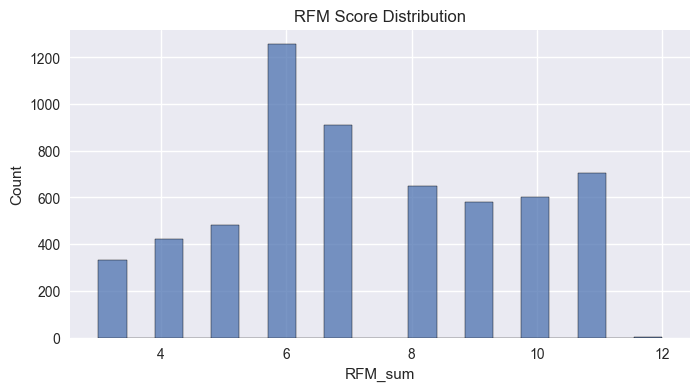

Saved RFM features -> E:\AI-Powered Customer Segmentation\data\processed\rfm_features.csv


In [27]:
# RFM (Recency, Frequency, Monetary) Analysis (Robust)
required_cols = {'invoice_date','customer_id'}
available = set(df_cust.columns)
missing = required_cols - available

# Try to infer customer_id if alternative naming
if 'customerid' in df_cust.columns and 'customer_id' not in df_cust.columns:
    df_cust = df_cust.rename(columns={'customerid':'customer_id'})
    available = set(df_cust.columns)
    missing = required_cols - available

if missing:
    print('RFM analysis skipped: missing columns ->', missing)
else:
    # Identify invoice number column variants
    invoice_col = None
    for cand in ['invoice','invoice_no','invoice_number','invoiceno']:
        if cand in df_cust.columns:
            invoice_col = cand
            break
    if invoice_col is None:
        # If no invoice id, we'll approximate frequency using distinct invoice_date days
        invoice_col = 'invoice_date'
        print('No explicit invoice number column found; using invoice_date for frequency approximation.')

    # Monetary value
    if 'total_price' not in df_cust.columns:
        qty_col = 'quantity' if 'quantity' in df_cust.columns else None
        price_col = None
        for cand in ['unit_price','price']:
            if cand in df_cust.columns:
                price_col = cand
                break
        if qty_col and price_col:
            df_cust['total_price'] = df_cust[qty_col] * df_cust[price_col]
            print("Constructed total_price from", qty_col, '*', price_col)
        else:
            print('Monetary fallback: using available numeric columns (may reduce accuracy).')

    snap_date = df_cust['invoice_date'].max() + pd.Timedelta(days=1)

    def frequency_agg(g):
        if invoice_col == 'invoice_date':
            return g.dt.to_period('D').nunique()
        return g.nunique()

    monetary_col = 'total_price' if 'total_price' in df_cust.columns else (
        'unit_price' if 'unit_price' in df_cust.columns else None)
    if monetary_col is None:
        # pick first numeric column excluding recency drivers
        numeric_candidates = [c for c in df_cust.select_dtypes(include='number').columns 
                              if c not in ['recency']]
        monetary_col = numeric_candidates[0] if numeric_candidates else None
        print('Selected fallback monetary column:', monetary_col)

    rfm = (df_cust
           .groupby('customer_id')
           .agg(recency=('invoice_date', lambda x: (snap_date - x.max()).days),
                frequency=(invoice_col, frequency_agg),
                monetary=(monetary_col, 'sum') if monetary_col else (invoice_col, 'count'))
          )

    rfm = rfm.replace([np.inf, -np.inf], np.nan).fillna(0)

    def score(series, reverse=False):
        if series.nunique() <= 1:
            return pd.Series([2]*len(series), index=series.index)
        q = series.quantile([0.25,0.5,0.75])
        def _s(v):
            if reverse: # lower better
                return 4 if v <= q[0.25] else 3 if v <= q[0.5] else 2 if v <= q[0.75] else 1
            return 1 if v <= q[0.25] else 2 if v <= q[0.5] else 3 if v <= q[0.75] else 4
        return series.apply(_s)

    rfm['R_score'] = score(rfm['recency'], reverse=True)
    rfm['F_score'] = score(rfm['frequency'])
    rfm['M_score'] = score(rfm['monetary'])
    rfm['RFM_sum'] = rfm[['R_score','F_score','M_score']].sum(axis=1)

    print('RFM snapshot:')
    display(rfm.head())
    print('RFM shape:', rfm.shape)

    plt.figure(figsize=(8,4))
    sns.histplot(rfm['RFM_sum'], bins=20, kde=False)
    plt.title('RFM Score Distribution')
    plt.show()

    # Persist for downstream modeling
    out_dir = Path(r"E:\AI-Powered Customer Segmentation\data\processed")
    out_dir.mkdir(parents=True, exist_ok=True)
    rfm_out = out_dir / 'rfm_features.csv'
    rfm.to_csv(rfm_out, index=True)
    print('Saved RFM features ->', rfm_out)

In [28]:
# Product Performance & Time Series
if 'stock_code' in df.columns and 'total_price' in df.columns:
    prod_perf = (df.groupby('stock_code')
                   .agg(revenue=('total_price','sum'),
                        qty=('quantity','sum') if 'quantity' in df.columns else ('total_price','count'))
                   .sort_values('revenue', ascending=False)
                )
    display(prod_perf.head(10))

    top_n = prod_perf.head(10)
    fig = px.bar(top_n.reset_index(), x='stock_code', y='revenue', title='Top 10 Products by Revenue')
    fig.show()

if 'invoice_date' in df.columns and 'total_price' in df.columns:
    ts = (df.set_index('invoice_date')
            .resample('W')['total_price']
            .sum())
    fig2 = px.line(ts.reset_index(), x='invoice_date', y='total_price', title='Weekly Revenue Trend')
    fig2.show()
else:
    print('Time series skipped: missing invoice_date or total_price')

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
# Cohort Analysis (Customer Retention)
if 'invoice_date' in df_cust.columns and 'customer_id' in df_cust.columns:
    tmp = df_cust[['customer_id','invoice_date']].dropna().copy()
    tmp['order_month'] = tmp['invoice_date'].dt.to_period('M').dt.to_timestamp()
    first_purchase = tmp.groupby('customer_id')['order_month'].min().rename('cohort')
    tmp = tmp.join(first_purchase, on='customer_id')
    tmp['cohort_index'] = ((tmp['order_month'].dt.year - tmp['cohort'].dt.year) * 12 +
                           (tmp['order_month'].dt.month - tmp['cohort'].dt.month) + 1)

    cohort_pivot = (tmp.groupby(['cohort','cohort_index'])['customer_id']
                      .nunique()
                      .reset_index())
    cohort_sizes = cohort_pivot[cohort_pivot['cohort_index']==1][['cohort','customer_id']]
    cohort_sizes = cohort_sizes.rename(columns={'customer_id':'cohort_size'})
    cohort_pivot = cohort_pivot.merge(cohort_sizes, on='cohort')
    cohort_pivot['retention'] = cohort_pivot['customer_id'] / cohort_pivot['cohort_size']

    retention_matrix = cohort_pivot.pivot(index='cohort', columns='cohort_index', values='retention')

    plt.figure(figsize=(12,6))
    sns.heatmap(retention_matrix, cmap='Blues', fmt='.0%', cbar=True)
    plt.title('Cohort Retention (%)')
    plt.ylabel('Cohort (First Purchase Month)')
    plt.xlabel('Cohort Index (Months Since First Purchase)')
    plt.show()
else:
    print('Cohort analysis skipped: required columns missing.')

Cohort analysis skipped: required columns missing.


## EDA Summary & Next Steps

**What we covered:**
- Loaded and standardized raw ecommerce dataset.
- Assessed data quality, removed high-null columns, engineered `total_price`.
- Generated descriptive statistics, distributions, correlations.
- Built RFM table with scoring for segmentation readiness.
- Identified top products and weekly revenue trends.
- Constructed cohort retention heatmap to understand churn dynamics.

**Immediate follow-ups:**
1. Outlier handling (extreme quantities / negative prices / cancellations if present).
2. Feature engineering: average order value, purchase frequency per time window, churn labels.
3. Prepare a modeling-ready dataset for clustering (scaled RFM + product category affinities).
4. Integrate with `clustering_engine.py` for prototype segmentation.
5. Add automated data quality checks to pipeline script.

Let me know if you want: automated export of RFM features, interactive dashboard, or model prep next.